In [15]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score
from keras.models import Sequential
from keras import layers
from keras.layers import Activation, Dense, Dropout
from keras.callbacks import EarlyStopping
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe


In [17]:
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    df = pd.read_csv("./stockPrice.csv", header=0, na_values='.')

    lol = df.copy()
    lol["1pred"] = (df["close"].shift(-1) - df["close"]) / df["close"]
    lol["3pred"] = (df["close"].shift(-3) - df["close"]) / df["close"]
    lol["5pred"] = (df["close"].shift(-5) - df["close"]) / df["close"]
    lol["10pred"] = (df["close"].shift(-10) - df["close"]) / df["close"]

    lol.loc[df["close"].shift(-1) > df["close"] , '1predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '1predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '3predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '3predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '5predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '5predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '10predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '10predB'] = 1

    lol["5max"] = lol["close"].rolling(window=5).max()
    lol["10max"] = lol["close"].rolling(window=10).max()
    lol["20max"] = lol["close"].rolling(window=20).max()

    lol["5low"] = lol["close"].rolling(window=5).min()
    lol["10low"] = lol["close"].rolling(window=10).min()
    lol["20low"] = lol["close"].rolling(window=20).min()

    lol["vol%"] =  (df["vol"] - df["vol"].shift(1)) /df["vol"].shift(1)

    lol = lol.dropna()    

    dfC = pd.DataFrame()
    dfC["vol"] = lol["vol%"]
    dfC["sma10"] = lol["sma10"] / lol["close"]
    dfC["sma20"] = lol["sma20"] / lol["close"]
    dfC["sma50"] = lol["sma50"] / lol["close"]
    dfC["sma100"] = lol["sma100"] / lol["close"]
    dfC["vwap"] = lol["vwap"]
    dfC["bbmid"] = lol["bbmid"] / lol["close"]
    dfC["bbUpper"] = lol["bbUpper"] / lol["close"]
    dfC["bbLower"] = lol["bbLower"] / lol["close"]
    dfC["cci"] = lol["cci"] 
    dfC["rsi"] = lol["rsi"] 
    dfC["5max"] = lol["5max"] / lol["close"]
    dfC["10max"] = lol["10max"] / lol["close"]
    dfC["20max"] = lol["20max"] / lol["close"]
    dfC["5low"] = lol["5low"] / lol["close"]
    dfC["10low"] = lol["10low"] / lol["close"]
    dfC["20low"] = lol["20low"] / lol["close"]
    dfC["1pred"] = lol["1pred"]
    dfC["3pred"] = lol["3pred"]
    dfC["5pred"] = lol["5pred"]
    dfC["10pred"] = lol["10pred"]
    dfC["1predB"] = lol["1predB"]
    dfC["3predB"] = lol["3predB"]
    dfC["5predB"] = lol["5predB"]
    dfC["10predB"] = lol["10predB"]

    dfC.replace([np.inf, -np.inf], np.nan)
    dfC.dropna(inplace=True)

    X = dfC[['sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low']]
    Y = dfC[["5predB"]]

    print(Y.head())
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    return x_train, y_train, x_test, y_test


def create_model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    input_dim = x_train.shape[1]  # Number of features
    output_dim = y_train.shape[1]  # Number of features
    


    model.add(Dense(512, input_dim=input_dim))
    model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))

    # If we choose 'four', add an additional fourth layer
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense(100))
        # We can also choose between complete sets of layers
        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))
        
    model.add(Dense(output_dim))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    result = model.fit(x_train, y_train,
             batch_size={{choice([16, 32, 64])}},
             epochs=100,
             validation_data=(x_test, y_test))

    score, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}




best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      notebook_name='kerasPriceB',
                                      trials=Trials())

X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import glob
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn import preprocessing
except:
    pass

try:
    from sklearn.metrics import accuracy_score
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, precision_score
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.layers import Activation, Dense, Dropout
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from hyperas import optim
except:
 

 - ETA: 0s - loss: 0.6941 - acc: 0.4777                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 236us/step - loss: 0.6939 - acc: 0.4834 - val_loss: 0.6950 - val_acc: 0.4898                                     

Epoch 4/100                                                                                                            
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6913 - acc: 0.5312                                                                                
                                                                                                                       
 256/1715 [===>........................

                                                                                                                       
 608/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5115                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5123                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6936 - acc: 0.5000 

 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.4896                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4931                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6939 - acc: 0.4976                                                                                
                                        

 - 0s 233us/step - loss: 0.6940 - acc: 0.5079 - val_loss: 0.6940 - val_acc: 0.4898                                     

Epoch 21/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6952 - acc: 0.4688                                                                                
                                                                                                                       
 320/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.4938                                                                                
                                                                                                                       
 576/1715 [=========>..................

                                                                                                                       
1216/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.4901                                                                                
                                                                                                                       
1504/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.4914                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 199us/step - loss: 0.6944 - acc: 0

 800/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5012                                                                                
                                                                                                                       
 928/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5054                                                                                
                                                                                                                       
1120/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.5009                                                                                
                                        

 - ETA: 0s - loss: 0.6957 - acc: 0.4688                                                                                
                                                                                                                       
 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6919 - acc: 0.5347                                                                                
                                                                                                                       
 480/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6911 - acc: 0.5417                                                                                
                                                                                                                       
 672/1715 [==========>..................

Epoch 41/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6915 - acc: 0.5312                                                                                
                                                                                                                       
 320/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6948 - acc: 0.4594                                                                                
                                                                                                                       
 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4614 

 416/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5168                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6936 - acc: 0.5069                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.5013                                                                                
                                        

 - ETA: 0s - loss: 0.6934 - acc: 0.5007                                                                                
                                                                                                                       
1504/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.4967                                                                                
                                                                                                                       
1696/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4965                                                                                
                                                                                                                       
1715/1715 [=============================

                                                                                                                       
 736/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.5068                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.5156                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5208 

 608/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.4819                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4935                                                                                
                                                                                                                       
 928/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.4828                                                                                
                                        

 - ETA: 0s - loss: 0.6921 - acc: 0.5625                                                                                
                                                                                                                       
 320/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6920 - acc: 0.5437                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5215                                                                                
                                                                                                                       
 704/1715 [===========>.................

                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4771                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4783                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4865 

1376/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4804                                                                                
                                                                                                                       
1664/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4802                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 213us/step - loss: 0.6941 - acc: 0.4793 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 74/100                           

 - ETA: 0s - loss: 0.6940 - acc: 0.4920                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 233us/step - loss: 0.6940 - acc: 0.4921 - val_loss: 0.6934 - val_acc: 0.4898                                     

Epoch 79/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6920 - acc: 0.5625                                                                                
                                                                                                                       
 256/1715 [===>........................

                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 232us/step - loss: 0.6936 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.5102                                     

Epoch 84/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.3438                                                                                
                                                                                                                       
 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4549

 416/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5120                                                                                
                                                                                                                       
 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.5000                                                                                
                                                                                                                       
 640/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.4922                                                                                
                                        

 - ETA: 0s - loss: 0.6937 - acc: 0.4688                                                                                
                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.4734                                                                                
                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4654                                                                                
                                                                                                                       
1600/1715 [==========================>..

                                                                                                                       
 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.5104                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.4961                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4909 

 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.4928                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4958                                                                                
                                                                                                                       
1120/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.4946                                                                                
                                        

  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6904 - acc: 0.6250                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5278                                                                                
                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5195                                                                                
                                        

 - ETA: 0s - loss: 0.6953 - acc: 0.4375                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6921 - acc: 0.5365                                                                                
                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5205                                                                                
                                                                                                                       
1408/1715 [=======================>.....

Epoch 25/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4688                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4705                                                                                
                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6936 - acc: 0.4893 

1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5078                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 140us/step - loss: 0.6929 - acc: 0.5079 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 34/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6917 - acc: 0.5469                                                                                
                                       

 - ETA: 0s - loss: 0.6928 - acc: 0.4980                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5012                                                                                
                                                                                                                       
1216/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5008                                                                                
                                                                                                                       
1664/1715 [============================>

                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6913 - acc: 0.5382                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6922 - acc: 0.5156                                                                                
                                                                                                                       
1600/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6922 - acc: 0.5150 

1715/1715 [==============================]                                                                             
 - 0s 123us/step - loss: 0.6921 - acc: 0.5079 - val_loss: 0.6936 - val_acc: 0.4898                                     

Epoch 60/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.4688                                                                                
                                                                                                                       
 640/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6915 - acc: 0.5141                                                                                
                                       

 - ETA: 0s - loss: 0.6917 - acc: 0.5143                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 130us/step - loss: 0.6917 - acc: 0.5149 - val_loss: 0.6929 - val_acc: 0.5224                                     

Epoch 69/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.4219                                                                                
                                                                                                                       
 640/1715 [==========>.................

                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 130us/step - loss: 0.6912 - acc: 0.5259 - val_loss: 0.6926 - val_acc: 0.5293                                     

Epoch 78/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6899 - acc: 0.4844                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6897 - acc: 0.5293

1715/1715 [==============================]                                                                             
 - 0s 128us/step - loss: 0.6907 - acc: 0.5324 - val_loss: 0.6926 - val_acc: 0.5333                                     

Epoch 87/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6908 - acc: 0.6406                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6911 - acc: 0.5332                                                                                
                                       

 - 0s 134us/step - loss: 0.6902 - acc: 0.5271 - val_loss: 0.6924 - val_acc: 0.5293                                     

Epoch 96/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6996 - acc: 0.5000                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6905 - acc: 0.5347                                                                                
                                                                                                                       
1024/1715 [================>...........

 - ETA: 0s - loss: 0.6959 - acc: 0.5061                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 129us/step - loss: 0.6954 - acc: 0.5085 - val_loss: 0.6940 - val_acc: 0.5102                                     

Epoch 5/100                                                                                                            
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5156                                                                                
                                                                                                                       
 576/1715 [=========>..................

                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.5014                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 124us/step - loss: 0.6941 - acc: 0.5038 - val_loss: 0.6945 - val_acc: 0.5102                                     

Epoch 14/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.7009 - acc: 0.4688

1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6980 - acc: 0.4635                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 133us/step - loss: 0.6969 - acc: 0.4723 - val_loss: 0.6930 - val_acc: 0.5102                                     

Epoch 23/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6912 - acc: 0.5469                                                                                
                                       

 - ETA: 0s - loss: 0.6951 - acc: 0.5115                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 129us/step - loss: 0.6957 - acc: 0.5055 - val_loss: 0.6930 - val_acc: 0.5102                                     

Epoch 32/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6945 - acc: 0.4219                                                                                
                                                                                                                       
 512/1715 [=======>....................

                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 128us/step - loss: 0.6953 - acc: 0.4991 - val_loss: 0.6934 - val_acc: 0.4898                                     

Epoch 41/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6954 - acc: 0.4375                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4948

1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.4901                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 137us/step - loss: 0.6945 - acc: 0.4910 - val_loss: 0.6933 - val_acc: 0.4925                                     

Epoch 50/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6922 - acc: 0.5625                                                                                
                                       

 - ETA: 0s - loss: 0.6912 - acc: 0.5299                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 138us/step - loss: 0.6924 - acc: 0.5230 - val_loss: 0.6938 - val_acc: 0.5102                                     

Epoch 59/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6958 - acc: 0.4688                                                                                
                                                                                                                       
 128/1715 [=>..........................

                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5122                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 130us/step - loss: 0.6935 - acc: 0.5073 - val_loss: 0.6937 - val_acc: 0.4912                                     

Epoch 68/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4688

1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.4935                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 125us/step - loss: 0.6936 - acc: 0.4939 - val_loss: 0.6947 - val_acc: 0.4898                                     

Epoch 77/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.7006 - acc: 0.5156                                                                                
                                       

 - ETA: 0s - loss: 0.6941 - acc: 0.5010                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4993                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 129us/step - loss: 0.6937 - acc: 0.5032 - val_loss: 0.6939 - val_acc: 0.4898                                     

Epoch 86/100                                                                                                           
  64/1715 [>...........................

                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6947 - acc: 0.4861                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.4802                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6948 - acc: 0.4957 

                                                                                                                       
1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6959 - acc: 0.4972                                                                                
                                                                                                                       
1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6958 - acc: 0.4992                                                                                
                                                                                                                       
1312/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6957 - acc: 0.4954 

  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6915 - acc: 0.6250                                                                                
                                                                                                                       
 160/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6918 - acc: 0.5500                                                                                
                                                                                                                       
 224/1715 [==>...........................]                                                                             
 - ETA: 0s - loss: 0.6916 - acc: 0.5536                                                                                
                                        

 - ETA: 0s - loss: 0.6931 - acc: 0.4959                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 294us/step - loss: 0.6931 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.4898                                     

Epoch 9/100                                                                                                            
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6954 - acc: 0.4062                                                                                
                                                                                                                       
 224/1715 [==>.........................

                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.4654                                                                                
                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.4668                                                                                
                                                                                                                       
1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6939 - acc: 0.4755 

1248/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4928                                                                                
                                                                                                                       
1376/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.4920                                                                                
                                                                                                                       
1504/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.4960                                                                                
                                        

 - ETA: 0s - loss: 0.6929 - acc: 0.5112                                                                                
                                                                                                                       
1440/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5028                                                                                
                                                                                                                       
1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5059                                                                                
                                                                                                                       
1632/1715 [===========================>.

                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.4944                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5000                                                                                
                                                                                                                       
1248/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5128 

  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6976 - acc: 0.4062                                                                                
                                                                                                                       
 224/1715 [==>...........................]                                                                             
 - ETA: 0s - loss: 0.6949 - acc: 0.4509                                                                                
                                                                                                                       
 384/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4635                                                                                
                                        

 - ETA: 0s - loss: 0.6928 - acc: 0.5095                                                                                
                                                                                                                       
1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5117                                                                                
                                                                                                                       
1664/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5090                                                                                
                                                                                                                       
1715/1715 [=============================

                                                                                                                       
 480/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.4979                                                                                
                                                                                                                       
 608/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5230                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5156 

1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5000                                                                                
                                                                                                                       
1440/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.4986                                                                                
                                                                                                                       
1600/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5012                                                                                
                                        

 - ETA: 0s - loss: 0.6931 - acc: 0.5045                                                                                
                                                                                                                       
1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5059                                                                                
                                                                                                                       
1664/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5012                                                                                
                                                                                                                       
1715/1715 [=============================

                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5015                                                                                
                                                                                                                       
1504/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5073                                                                                
                                                                                                                       
1696/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5035 

 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5167                                                                                
                                                                                                                       
1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5142                                                                                
                                                                                                                       
1216/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6922 - acc: 0.5074                                                                                
                                        

 - ETA: 0s - loss: 0.6927 - acc: 0.5078                                                                                
                                                                                                                       
 928/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5022                                                                                
                                                                                                                       
1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5114                                                                                
                                                                                                                       
1216/1715 [====================>........

                                                                                                                       
 704/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.4957                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.4856                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.4917 

 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6925 - acc: 0.5165                                                                                
                                                                                                                       
 704/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5142                                                                                
                                                                                                                       
 864/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5150                                                                                
                                        

 - ETA: 0s - loss: 0.6922 - acc: 0.5230                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5130                                                                                
                                                                                                                       
 928/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6923 - acc: 0.5248                                                                                
                                                                                                                       
1056/1715 [=================>...........

                                                                                                                       
 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5184                                                                                
                                                                                                                       
 736/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5068                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.5045 

 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6913 - acc: 0.5059                                                                                
                                                                                                                       
 640/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6922 - acc: 0.5031                                                                                
                                                                                                                       
 800/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6917 - acc: 0.5088                                                                                
                                        

 - ETA: 0s - loss: 0.6927 - acc: 0.5025                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 370us/step - loss: 0.6929 - acc: 0.5026 - val_loss: 0.6933 - val_acc: 0.4898                                     

Epoch 79/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.4375                                                                                
                                                                                                                       
 224/1715 [==>.........................

                                                                                                                       
 928/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5097                                                                                
                                                                                                                       
1120/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5009                                                                                
                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5078 

 192/1715 [==>...........................]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.5156                                                                                
                                                                                                                       
 352/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5028                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5078                                                                                
                                        

 - ETA: 0s - loss: 0.6934 - acc: 0.5094                                                                                
                                                                                                                       
1440/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5076                                                                                
                                                                                                                       
1568/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5159                                                                                
                                                                                                                       
1715/1715 [=============================

                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5078                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6923 - acc: 0.5122                                                                                
                                                                                                                       
1312/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6925 - acc: 0.5099 

 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5295                                                                                
                                                                                                                       
 736/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5204                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5078                                                                                
                                        

 - ETA: 0s - loss: 0.6932 - acc: 0.4988                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 374us/step - loss: 0.6930 - acc: 0.5026 - val_loss: 0.6937 - val_acc: 0.4980                                     

Test accuracy:                                                                                                         
0.49795918302471137                                                                                                    
16                                                                                                                     
Train on 1715 samples, validate on 735 samples                                                                         
Epoch 1/100                            

 - ETA: 0s - loss: 0.6934 - acc: 0.4922                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5030                                                                                
                                                                                                                       
1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5072                                                                                
                                                                                                                       
1715/1715 [=============================

                                                                                                                       
 640/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5141                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5120                                                                                
                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5068 

1715/1715 [==============================]                                                                             
 - 0s 169us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6936 - val_acc: 0.4898                                     

Epoch 21/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6911 - acc: 0.5625                                                                                
                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.4933                                                                                
                                       

 - ETA: 0s - loss: 0.6929 - acc: 0.5117                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 162us/step - loss: 0.6930 - acc: 0.5079 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 28/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5000                                                                                
                                                                                                                       
 448/1715 [======>.....................

                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5078                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5028                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5060 

1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.4993                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 168us/step - loss: 0.6930 - acc: 0.5079 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 41/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5156                                                                                
                                       

 - ETA: 0s - loss: 0.6926 - acc: 0.5204                                                                                
                                                                                                                       
1216/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5156                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5092                                                                                
                                                                                                                       
1664/1715 [============================>

                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5104                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5110                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5092 

1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5111                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 174us/step - loss: 0.6929 - acc: 0.5079 - val_loss: 0.6938 - val_acc: 0.4898                                     

Epoch 62/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6913 - acc: 0.5156                                                                                
                                       

 - 0s 171us/step - loss: 0.6929 - acc: 0.5032 - val_loss: 0.6934 - val_acc: 0.4898                                     

Epoch 69/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6908 - acc: 0.6094                                                                                
                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4933                                                                                
                                                                                                                       
 640/1715 [==========>.................

                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5027                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 167us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6937 - val_acc: 0.4898                                     

Epoch 76/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6888 - acc: 0.6250

1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5059                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 165us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6936 - val_acc: 0.4898                                     

Epoch 83/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6891 - acc: 0.6250                                                                                
                                       

 - 0s 174us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6936 - val_acc: 0.4898                                     

Epoch 90/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6948 - acc: 0.4531                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5078                                                                                
                                                                                                                       
 768/1715 [============>...............

                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5148                                                                                
                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5082                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 171us/step - loss: 0.6931 - acc: 0

                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4905                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 134us/step - loss: 0.6934 - acc: 0.4980 - val_loss: 0.6939 - val_acc: 0.4898                                     

Epoch 4/100                                                                                                            
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6949 - acc: 0.4688

 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5177                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5149                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 136us/step - loss: 0.6935 - acc: 0.5050 - val_loss: 0.6930 - val_acc: 0.5102                                     

Epoch 13/100                           

 - ETA: 0s - loss: 0.6935 - acc: 0.5057                                                                                
                                                                                                                       
1664/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5084                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 243us/step - loss: 0.6934 - acc: 0.5079 - val_loss: 0.6938 - val_acc: 0.4898                                     

Epoch 21/100                                                                                                           
  64/1715 [>...........................

                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.4866                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 141us/step - loss: 0.6934 - acc: 0.4939 - val_loss: 0.6938 - val_acc: 0.4898                                     

Epoch 30/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6919 - acc: 0.5312

  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4688                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5293                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5179                                                                                
                                        

 - ETA: 0s - loss: 0.6922 - acc: 0.5284                                                                                
                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5109                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 99us/step - loss: 0.6934 - acc: 0.5079 - val_loss: 0.6934 - val_acc: 0.4898                                      

Epoch 47/100                                                                                                           
  64/1715 [>...........................

                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.4969                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 99us/step - loss: 0.6933 - acc: 0.4997 - val_loss: 0.6938 - val_acc: 0.4898                                      

Epoch 56/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6907 - acc: 0.5625

1715/1715 [==============================]                                                                             
 - 0s 102us/step - loss: 0.6934 - acc: 0.5026 - val_loss: 0.6930 - val_acc: 0.5102                                     

Epoch 66/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5312                                                                                
                                                                                                                       
 704/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5128                                                                                
                                       

 - ETA: 0s - loss: 0.6938 - acc: 0.4893                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 167us/step - loss: 0.6935 - acc: 0.5009 - val_loss: 0.6942 - val_acc: 0.4898                                     

Epoch 76/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6972 - acc: 0.4375                                                                                
                                                                                                                       
 640/1715 [==========>.................

                                                                                                                       
1216/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4811                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 102us/step - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6944 - val_acc: 0.4898                                     

Epoch 87/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6873 - acc: 0.5938

 640/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5141                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5184                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5170                                                                                
                                        

 240/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6967 - acc: 0.5000                                                                                
                                                                                                                       
 352/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6968 - acc: 0.4943                                                                                
                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6962 - acc: 0.5045                                                                                
                                        

 - ETA: 0s - loss: 0.6996 - acc: 0.4779                                                                                
                                                                                                                       
1440/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6999 - acc: 0.4708                                                                                
                                                                                                                       
1568/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.7006 - acc: 0.4700                                                                                
                                                                                                                       
1696/1715 [============================>

                                                                                                                       
1264/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6974 - acc: 0.4945                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6971 - acc: 0.4963                                                                                
                                                                                                                       
1424/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6973 - acc: 0.4958 

 432/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6950 - acc: 0.5139                                                                                
                                                                                                                       
 496/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6950 - acc: 0.5101                                                                                
                                                                                                                       
 560/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6948 - acc: 0.5036                                                                                
                                        

 - ETA: 0s - loss: 0.6963 - acc: 0.4964                                                                                
                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6963 - acc: 0.4980                                                                                
                                                                                                                       
1568/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6966 - acc: 0.4968                                                                                
                                                                                                                       
1696/1715 [============================>

                                                                                                                       
 352/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6947 - acc: 0.5199                                                                                
                                                                                                                       
 464/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.5323                                                                                
                                                                                                                       
 592/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6948 - acc: 0.5186 

1296/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6956 - acc: 0.4900                                                                                
                                                                                                                       
1424/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6956 - acc: 0.4937                                                                                
                                                                                                                       
1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6959 - acc: 0.4922                                                                                
                                        

 - ETA: 0s - loss: 0.6845 - acc: 0.6250                                                                                
                                                                                                                       
  96/1715 [>.............................]                                                                             
 - ETA: 1s - loss: 0.6969 - acc: 0.5208                                                                                
                                                                                                                       
 160/1715 [=>............................]                                                                             
 - ETA: 1s - loss: 0.6945 - acc: 0.5312                                                                                
                                                                                                                       
 176/1715 [==>..........................

                                                                                                                       
 336/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.7073 - acc: 0.4792                                                                                
                                                                                                                       
 432/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.7032 - acc: 0.5023                                                                                
                                                                                                                       
 528/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.7029 - acc: 0.4981 

 480/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.5021                                                                                
                                                                                                                       
 608/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6949 - acc: 0.4901                                                                                
                                                                                                                       
 688/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6955 - acc: 0.4855                                                                                
                                        

 - ETA: 0s - loss: 0.6950 - acc: 0.5031                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 599us/step - loss: 0.6953 - acc: 0.5003 - val_loss: 0.6941 - val_acc: 0.4844                                     

Epoch 27/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6976 - acc: 0.3750                                                                                
                                                                                                                       
 160/1715 [=>..........................

                                                                                                                       
1232/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6963 - acc: 0.4894                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6967 - acc: 0.4792                                                                                
                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6962 - acc: 0.4803 

 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6984 - acc: 0.4890                                                                                
                                                                                                                       
 656/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6951 - acc: 0.5030                                                                                
                                                                                                                       
 736/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6949 - acc: 0.5095                                                                                
                                        

 - ETA: 0s - loss: 0.6972 - acc: 0.5140                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6966 - acc: 0.5179                                                                                
                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6963 - acc: 0.5149                                                                                
                                                                                                                       
1584/1715 [==========================>..

                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6917 - acc: 0.5352                                                                                
                                                                                                                       
1392/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6916 - acc: 0.5302                                                                                
                                                                                                                       
1520/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6911 - acc: 0.5296 

1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6962 - acc: 0.4896                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6964 - acc: 0.4896                                                                                
                                                                                                                       
1248/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6964 - acc: 0.4880                                                                                
                                        

 - 1s 572us/step - loss: 0.6951 - acc: 0.5050 - val_loss: 0.6951 - val_acc: 0.5102                                     

Epoch 43/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.7175 - acc: 0.3750                                                                                
                                                                                                                       
 160/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6980 - acc: 0.4625                                                                                
                                                                                                                       
 272/1715 [===>........................

                                                                                                                       
 416/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6992 - acc: 0.4880                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6981 - acc: 0.4902                                                                                
                                                                                                                       
 592/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6980 - acc: 0.4814 

 496/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6878 - acc: 0.5423                                                                                
                                                                                                                       
 592/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6888 - acc: 0.5389                                                                                
                                                                                                                       
 688/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6887 - acc: 0.5247                                                                                
                                        

 - ETA: 0s - loss: 0.6898 - acc: 0.5132                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6908 - acc: 0.5104                                                                                
                                                                                                                       
1072/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6917 - acc: 0.5047                                                                                
                                                                                                                       
1184/1715 [===================>.........

                                                                                                                       
1264/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4945                                                                                
                                                                                                                       
1360/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4978                                                                                
                                                                                                                       
1392/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4943 

 912/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.5121                                                                                
                                                                                                                       
 992/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.5071                                                                                
                                                                                                                       
1072/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.5056                                                                                
                                        

 - ETA: 0s - loss: 0.6938 - acc: 0.5000                                                                                
                                                                                                                       
1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4943                                                                                
                                                                                                                       
1168/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.4974                                                                                
                                                                                                                       
1280/1715 [=====================>.......

                                                                                                                       
1040/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6949 - acc: 0.4962                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6954 - acc: 0.4931                                                                                
                                                                                                                       
1264/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6951 - acc: 0.4945 

1520/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.5079                                                                                
                                                                                                                       
1632/1715 [===========================>..]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.5080                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 555us/step - loss: 0.6942 - acc: 0.5085 - val_loss: 0.6928 - val_acc: 0.5224                                     

Epoch 60/100                           

 - ETA: 0s - loss: 0.6950 - acc: 0.4828                                                                                
                                                                                                                       
1040/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.4846                                                                                
                                                                                                                       
1168/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6951 - acc: 0.4820                                                                                
                                                                                                                       
1232/1715 [====================>........

                                                                                                                       
 480/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6920 - acc: 0.5354                                                                                
                                                                                                                       
 608/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6921 - acc: 0.5296                                                                                
                                                                                                                       
 720/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6939 - acc: 0.5236 

1424/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6958 - acc: 0.5056                                                                                
                                                                                                                       
1504/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6962 - acc: 0.4993                                                                                
                                                                                                                       
1584/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6964 - acc: 0.5006                                                                                
                                        

 - 1s 696us/step - loss: 0.6941 - acc: 0.5061 - val_loss: 0.6946 - val_acc: 0.5102                                     

Epoch 70/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 1s - loss: 0.6959 - acc: 0.4375                                                                                
                                                                                                                       
  96/1715 [>.............................]                                                                             
 - ETA: 1s - loss: 0.6925 - acc: 0.5104                                                                                
                                                                                                                       
 144/1715 [=>..........................

                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.4971                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.5069                                                                                
                                                                                                                       
1248/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.5072 

 480/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6941 - acc: 0.4583                                                                                
                                                                                                                       
 592/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.4713                                                                                
                                                                                                                       
 688/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6922 - acc: 0.4884                                                                                
                                        

 - 1s 511us/step - loss: 0.6961 - acc: 0.4816 - val_loss: 0.6979 - val_acc: 0.5102                                     

Epoch 78/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6920 - acc: 0.5625                                                                                
                                                                                                                       
 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6892 - acc: 0.5208                                                                                
                                                                                                                       
 272/1715 [===>........................

                                                                                                                       
1488/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.5060                                                                                
                                                                                                                       
1600/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6953 - acc: 0.5025                                                                                
                                                                                                                       
1712/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6952 - acc: 0.5012 

 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6958 - acc: 0.5022                                                                                
                                                                                                                       
1024/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6963 - acc: 0.4990                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6967 - acc: 0.4991                                                                                
                                        

 - ETA: 0s - loss: 0.6958 - acc: 0.5000                                                                                
                                                                                                                       
 672/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6958 - acc: 0.5074                                                                                
                                                                                                                       
 800/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6949 - acc: 0.4950                                                                                
                                                                                                                       
 896/1715 [==============>..............

                                                                                                                       
 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6968 - acc: 0.5139                                                                                
                                                                                                                       
 272/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6883 - acc: 0.5515                                                                                
                                                                                                                       
 384/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6831 - acc: 0.5755 

1680/1715 [============================>.]                                                                             
 - ETA: 0s - loss: 0.6918 - acc: 0.5185                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 496us/step - loss: 0.6914 - acc: 0.5184 - val_loss: 0.7050 - val_acc: 0.4857                                     

Epoch 92/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.7149 - acc: 0.3125                                                                                
                                       

 - ETA: 0s - loss: 0.6950 - acc: 0.5152                                                                                
                                                                                                                       
1136/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.5158                                                                                
                                                                                                                       
1200/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5200                                                                                
                                                                                                                       
1280/1715 [=====================>.......

                                                                                                                       
1456/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5117                                                                                
                                                                                                                       
1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6925 - acc: 0.5130                                                                                
                                                                                                                       
1600/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6925 - acc: 0.5094 

  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6803 - acc: 0.5625                                                                                
                                                                                                                       
 128/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6877 - acc: 0.5469                                                                                
                                                                                                                       
 192/1715 [==>...........................]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5156                                                                                
                                        

 - 1s 776us/step - loss: 0.6937 - acc: 0.5195 - val_loss: 0.7014 - val_acc: 0.4857                                     

Test accuracy:                                                                                                         
0.4857142862008542                                                                                                     
16                                                                                                                     
Train on 1715 samples, validate on 735 samples                                                                         
Epoch 1/100                                                                                                            
  32/1715 [..............................]                                                                             
 - ETA: 1:08 - loss: 1.0430 - acc: 0.4375                                                                              
                                       

 - ETA: 0s - loss: 0.6968 - acc: 0.4813                                                                                
                                                                                                                       
1312/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6974 - acc: 0.4787                                                                                
                                                                                                                       
1440/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6970 - acc: 0.4833                                                                                
                                                                                                                       
1568/1715 [==========================>..

                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6957 - acc: 0.4688                                                                                
                                                                                                                       
 672/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6975 - acc: 0.4702                                                                                
                                                                                                                       
 864/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6975 - acc: 0.4676 

1600/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6957 - acc: 0.5069                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 268us/step - loss: 0.6958 - acc: 0.5044 - val_loss: 0.6972 - val_acc: 0.4898                                     

Epoch 15/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6747 - acc: 0.6562                                                                                
                                       

 - ETA: 0s - loss: 0.7011 - acc: 0.4892                                                                                
                                                                                                                       
1120/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.7006 - acc: 0.4955                                                                                
                                                                                                                       
1312/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.7003 - acc: 0.4931                                                                                
                                                                                                                       
1504/1715 [=========================>...

Epoch 24/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.7044 - acc: 0.4688                                                                                
                                                                                                                       
 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.7004 - acc: 0.4618                                                                                
                                                                                                                       
 480/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6992 - acc: 0.4688 

1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6921 - acc: 0.5203                                                                                
                                                                                                                       
1376/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5160                                                                                
                                                                                                                       
1536/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5117                                                                                
                                        

 - ETA: 0s - loss: 0.6930 - acc: 0.5208                                                                                
                                                                                                                       
 672/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.5193                                                                                
                                                                                                                       
 864/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6953 - acc: 0.5069                                                                                
                                                                                                                       
1088/1715 [==================>..........

                                                                                                                       
1312/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6936 - acc: 0.5122                                                                                
                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.5156                                                                                
                                                                                                                       
1632/1715 [===========================>..]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.5172 

 320/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6959 - acc: 0.4969                                                                                
                                                                                                                       
 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6950 - acc: 0.4926                                                                                
                                                                                                                       
 736/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6979 - acc: 0.4674                                                                                
                                        

 - ETA: 0s - loss: 0.6937 - acc: 0.5163                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6955 - acc: 0.5094                                                                                
                                                                                                                       
1216/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6953 - acc: 0.5008                                                                                
                                                                                                                       
1472/1715 [========================>....

                                                                                                                       
1248/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6951 - acc: 0.5160                                                                                
                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6955 - acc: 0.5136                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 275us/step - loss: 0.6959 - acc: 0

 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5174                                                                                
                                                                                                                       
 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.5037                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6950 - acc: 0.4940                                                                                
                                        

 - ETA: 0s - loss: 0.6923 - acc: 0.5000                                                                                
                                                                                                                       
 320/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5125                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6939 - acc: 0.5017                                                                                
                                                                                                                       
 832/1715 [=============>...............

                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6952 - acc: 0.5074                                                                                
                                                                                                                       
1600/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6963 - acc: 0.4969                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 221us/step - loss: 0.6961 - acc: 0

 256/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6991 - acc: 0.5000                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6968 - acc: 0.4922                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6984 - acc: 0.4818                                                                                
                                        

 - ETA: 0s - loss: 0.6981 - acc: 0.4764                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 229us/step - loss: 0.6979 - acc: 0.4822 - val_loss: 0.7156 - val_acc: 0.4898                                     

Epoch 81/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6983 - acc: 0.5312                                                                                
                                                                                                                       
 320/1715 [====>.......................

                                                                                                                       
 480/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6958 - acc: 0.4646                                                                                
                                                                                                                       
 704/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.4872                                                                                
                                                                                                                       
 928/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6957 - acc: 0.4752 

 704/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6955 - acc: 0.5000                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6950 - acc: 0.5033                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6946 - acc: 0.5018                                                                                
                                        

 - 1s 295us/step - loss: 0.6960 - acc: 0.4985 - val_loss: 0.6960 - val_acc: 0.4898                                     

Epoch 95/100                                                                                                           
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6863 - acc: 0.5625                                                                                
                                                                                                                       
 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6939 - acc: 0.5139                                                                                
                                                                                                                       
 448/1715 [======>.....................

                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 268us/step - loss: 0.6940 - acc: 0.5067 - val_loss: 0.6937 - val_acc: 0.4898                                     

Epoch 100/100                                                                                                          
  32/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6980 - acc: 0.2500                                                                                
                                                                                                                       
 288/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6974 - acc: 0.4722

                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6991 - acc: 0.4844                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6984 - acc: 0.4927                                                                                
                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6972 - acc: 0.4961 

 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6964 - acc: 0.5022                                                                                
                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6961 - acc: 0.4896                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6962 - acc: 0.4868                                                                                
                                        

 - ETA: 0s - loss: 0.6981 - acc: 0.5059                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6965 - acc: 0.5190                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6974 - acc: 0.5164                                                                                
                                                                                                                       
1664/1715 [============================>

                                                                                                                       
1472/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6956 - acc: 0.4986                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 167us/step - loss: 0.6934 - acc: 0.5114 - val_loss: 0.7174 - val_acc: 0.4898                                     

Epoch 28/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.7259 - acc: 0.4688

  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6888 - acc: 0.5469                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6993 - acc: 0.4961                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6981 - acc: 0.4933                                                                                
                                        

 - ETA: 0s - loss: 0.6960 - acc: 0.4871                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 169us/step - loss: 0.6957 - acc: 0.4898 - val_loss: 0.6950 - val_acc: 0.4898                                     

Epoch 43/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6927 - acc: 0.5156                                                                                
                                                                                                                       
 448/1715 [======>.....................

                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.5067                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6963 - acc: 0.4987                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6944 - acc: 0.5129 

1715/1715 [==============================]                                                                             
 - 0s 162us/step - loss: 0.6952 - acc: 0.5067 - val_loss: 0.7002 - val_acc: 0.4898                                     

Epoch 58/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6856 - acc: 0.5625                                                                                
                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6959 - acc: 0.4955                                                                                
                                       

 - ETA: 0s - loss: 0.6991 - acc: 0.4883                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6983 - acc: 0.4936                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6979 - acc: 0.4874                                                                                
                                                                                                                       
1536/1715 [=========================>...

                                                                                                                       
 576/1715 [=========>....................]                                                                             
 - ETA: 0s - loss: 0.6986 - acc: 0.4792                                                                                
                                                                                                                       
 896/1715 [==============>...............]                                                                             
 - ETA: 0s - loss: 0.6998 - acc: 0.4900                                                                                
                                                                                                                       
1216/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.7002 - acc: 0.4827 

  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5000                                                                                
                                                                                                                       
 512/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.4902                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6951 - acc: 0.5024                                                                                
                                        

 - ETA: 0s - loss: 0.6975 - acc: 0.4872                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 0s 178us/step - loss: 0.6970 - acc: 0.4904 - val_loss: 0.6931 - val_acc: 0.5102                                     

Epoch 86/100                                                                                                           
  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5156                                                                                
                                                                                                                       
 384/1715 [=====>......................

                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6973 - acc: 0.4948                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6983 - acc: 0.4905                                                                                
                                                                                                                       
1408/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6994 - acc: 0.4936 

  64/1715 [>.............................]                                                                             
 - ETA: 0s - loss: 0.7010 - acc: 0.4375                                                                                
                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6981 - acc: 0.5089                                                                                
                                                                                                                       
 640/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6984 - acc: 0.4906                                                                                
                                        

 976/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5123                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5083                                                                                
                                                                                                                       
1168/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5077                                                                                
                                        

 - ETA: 0s - loss: 0.6931 - acc: 0.5094                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 561us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 5/100                                                                                                            
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6949 - acc: 0.4375                                                                                
                                                                                                                       
 144/1715 [=>..........................

                                                                                                                       
 944/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5021                                                                                
                                                                                                                       
1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4972                                                                                
                                                                                                                       
1168/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5000 

1715/1715 [==============================]                                                                             
 - 1s 603us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 10/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6969 - acc: 0.3750                                                                                
                                                                                                                       
 128/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6948 - acc: 0.4453                                                                                
                                       

 - ETA: 0s - loss: 0.6926 - acc: 0.5191                                                                                
                                                                                                                       
 688/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5247                                                                                
                                                                                                                       
 768/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5039                                                                                
                                                                                                                       
 864/1715 [==============>..............

                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4972                                                                                
                                                                                                                       
1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5008                                                                                
                                                                                                                       
1264/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5047 

1632/1715 [===========================>..]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5116                                                                                
                                                                                                                       
1715/1715 [==============================]                                                                             
 - 1s 635us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6937 - val_acc: 0.4898                                     

Epoch 17/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 1s - loss: 0.6884 - acc: 0.6250                                                                                
                                       

 - ETA: 0s - loss: 0.6943 - acc: 0.4653                                                                                
                                                                                                                       
 256/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6945 - acc: 0.4570                                                                                
                                                                                                                       
 336/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6939 - acc: 0.4792                                                                                
                                                                                                                       
 416/1715 [======>......................

                                                                                                                       
 688/1715 [===========>..................]                                                                             
 - ETA: 0s - loss: 0.6923 - acc: 0.5262                                                                                
                                                                                                                       
 752/1715 [============>.................]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5239                                                                                
                                                                                                                       
 832/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5156 

 944/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5053                                                                                
                                                                                                                       
1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5142                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5165                                                                                
                                        

 - ETA: 0s - loss: 0.6917 - acc: 0.5625                                                                                
                                                                                                                       
 128/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5156                                                                                
                                                                                                                       
 208/1715 [==>...........................]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5240                                                                                
                                                                                                                       
 288/1715 [====>........................

                                                                                                                       
 848/1715 [=============>................]                                                                             
 - ETA: 0s - loss: 0.6936 - acc: 0.4929                                                                                
                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6936 - acc: 0.4917                                                                                
                                                                                                                       
1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.4934 

1392/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5079                                                                                
                                                                                                                       
1504/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5093                                                                                
                                                                                                                       
1584/1715 [==========================>...]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5088                                                                                
                                        

 - ETA: 0s - loss: 0.6915 - acc: 0.5547                                                                                
                                                                                                                       
 224/1715 [==>...........................]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5179                                                                                
                                                                                                                       
 320/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6918 - acc: 0.5406                                                                                
                                                                                                                       
 432/1715 [======>......................

                                                                                                                       
 432/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5278                                                                                
                                                                                                                       
 544/1715 [========>.....................]                                                                             
 - ETA: 0s - loss: 0.6923 - acc: 0.5276                                                                                
                                                                                                                       
 640/1715 [==========>...................]                                                                             
 - ETA: 0s - loss: 0.6924 - acc: 0.5250 

1232/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5130                                                                                
                                                                                                                       
1344/1715 [======================>.......]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5134                                                                                
                                                                                                                       
1440/1715 [========================>.....]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5118                                                                                
                                        

 - ETA: 0s - loss: 0.6924 - acc: 0.5273                                                                                
                                                                                                                       
 368/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5217                                                                                
                                                                                                                       
 448/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6925 - acc: 0.5223                                                                                
                                                                                                                       
 544/1715 [========>....................

                                                                                                                       
1168/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5043                                                                                
                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.5000                                                                                
                                                                                                                       
1376/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5087 

 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5139                                                                                
                                                                                                                       
 240/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6921 - acc: 0.5375                                                                                
                                                                                                                       
 352/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6920 - acc: 0.5398                                                                                
                                        

 - ETA: 0s - loss: 0.6929 - acc: 0.5123                                                                                
                                                                                                                       
1072/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5168                                                                                
                                                                                                                       
1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5160                                                                                
                                                                                                                       
1296/1715 [=====================>.......

                                                                                                                       
 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6938 - acc: 0.4722                                                                                
                                                                                                                       
 256/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6936 - acc: 0.4805                                                                                
                                                                                                                       
 352/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6935 - acc: 0.4886 

1040/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5019                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4974                                                                                
                                                                                                                       
1232/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5057                                                                                
                                        

 - 1s 553us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6936 - val_acc: 0.4898                                     

Epoch 55/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5000                                                                                
                                                                                                                       
 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6921 - acc: 0.5347                                                                                
                                                                                                                       
 240/1715 [===>........................

                                                                                                                       
 976/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5164                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5156                                                                                
                                                                                                                       
1200/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5158 

1715/1715 [==============================]                                                                             
 - 1s 577us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 60/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6978 - acc: 0.3125                                                                                
                                                                                                                       
 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6943 - acc: 0.4514                                                                                
                                       

 - ETA: 0s - loss: 0.6929 - acc: 0.5116                                                                                
                                                                                                                       
 976/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5154                                                                                
                                                                                                                       
1072/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5112                                                                                
                                                                                                                       
1168/1715 [===================>.........

Epoch 65/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5000                                                                                
                                                                                                                       
 128/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6942 - acc: 0.4688                                                                                
                                                                                                                       
 224/1715 [==>...........................]                                                                             
 - ETA: 0s - loss: 0.6934 - acc: 0.4955 

 992/1715 [================>.............]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5040                                                                                
                                                                                                                       
1088/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5018                                                                                
                                                                                                                       
1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5084                                                                                
                                        

 - ETA: 0s - loss: 0.6933 - acc: 0.5000                                                                                
                                                                                                                       
 160/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5125                                                                                
                                                                                                                       
 240/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5042                                                                                
                                                                                                                       
 336/1715 [====>........................

                                                                                                                       
1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5017                                                                                
                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5031                                                                                
                                                                                                                       
1376/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5051 

1715/1715 [==============================]                                                                             
 - 1s 555us/step - loss: 0.6932 - acc: 0.5079 - val_loss: 0.6935 - val_acc: 0.4898                                     

Epoch 75/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6899 - acc: 0.6250                                                                                
                                                                                                                       
 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6951 - acc: 0.4514                                                                                
                                       

 - ETA: 0s - loss: 0.6925 - acc: 0.5248                                                                                
                                                                                                                       
1120/1715 [==================>...........]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5214                                                                                
                                                                                                                       
1232/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6929 - acc: 0.5146                                                                                
                                                                                                                       
1328/1715 [======================>......

                                                                                                                       
 272/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.4853                                                                                
                                                                                                                       
 368/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6940 - acc: 0.4728                                                                                
                                                                                                                       
 496/1715 [=======>......................]                                                                             
 - ETA: 0s - loss: 0.6937 - acc: 0.4859 

1056/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5028                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5061                                                                                
                                                                                                                       
1248/1715 [====================>.........]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5056                                                                                
                                        

 - ETA: 0s - loss: 0.6919 - acc: 0.5491                                                                                
                                                                                                                       
 336/1715 [====>.........................]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5119                                                                                
                                                                                                                       
 432/1715 [======>.......................]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5185                                                                                
                                                                                                                       
 528/1715 [========>....................

                                                                                                                       
1296/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.5008                                                                                
                                                                                                                       
1392/1715 [=======================>......]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5036                                                                                
                                                                                                                       
1504/1715 [=========================>....]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5093 

 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6933 - acc: 0.4979                                                                                
                                                                                                                       
1072/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5065                                                                                
                                                                                                                       
1184/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6931 - acc: 0.5076                                                                                
                                        

 - 1s 560us/step - loss: 0.6931 - acc: 0.5079 - val_loss: 0.6936 - val_acc: 0.4898                                     

Epoch 93/100                                                                                                           
  16/1715 [..............................]                                                                             
 - ETA: 0s - loss: 0.6958 - acc: 0.4375                                                                                
                                                                                                                       
 144/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6947 - acc: 0.4583                                                                                
                                                                                                                       
 224/1715 [==>.........................

                                                                                                                       
 960/1715 [===============>..............]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5250                                                                                
                                                                                                                       
1072/1715 [=================>............]                                                                             
 - ETA: 0s - loss: 0.6928 - acc: 0.5187                                                                                
                                                                                                                       
1168/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5111 

 160/1715 [=>............................]                                                                             
 - ETA: 0s - loss: 0.6910 - acc: 0.5687                                                                                
                                                                                                                       
 272/1715 [===>..........................]                                                                             
 - ETA: 0s - loss: 0.6930 - acc: 0.5147                                                                                
                                                                                                                       
 352/1715 [=====>........................]                                                                             
 - ETA: 0s - loss: 0.6932 - acc: 0.5085                                                                                
                                        

 - ETA: 0s - loss: 0.6927 - acc: 0.5166                                                                                
                                                                                                                       
1152/1715 [===================>..........]                                                                             
 - ETA: 0s - loss: 0.6925 - acc: 0.5217                                                                                
                                                                                                                       
1280/1715 [=====================>........]                                                                             
 - ETA: 0s - loss: 0.6926 - acc: 0.5203                                                                                
                                                                                                                       
1392/1715 [=======================>.....

In [18]:
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Evalutation of best performing model:
735/735 [==============================] - ETA:  - 0s 69us/step
[0.6924264131760111, 0.510204081186632]
Best performing model chosen hyper-parameters:
{'Activation': 1, 'Activation_1': 2, 'Activation_2': 2, 'Activation_3': 0, 'Activation_4': 1, 'Dense': 2, 'Dense_1': 0, 'add': 1, 'batch_size': 2, 'optimizer': 0}


In [19]:
x_train, y_train, x_test, y_test = data()
input_dim = x_train.shape[1]  # Number of features
output_dim = y_train.shape[1]  # Number of features
# print(y_test.head())
model = Sequential()

model.add(Dense(512, input_dim=input_dim))
model.add(Activation('sigmoid'))
model.add(Dense(1024))
model.add(Activation('softmax'))
model.add(Dense(256))
model.add(Activation('softmax'))
# add
# model.add(Dense(100))
# model.add(Dropout(0.5))
# model.add(Activation('sigmoid'))

model.add(Dense(output_dim))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'],
              optimizer='rmsprop')

model_output = model.fit(x_train, y_train,
             batch_size=64,
             epochs=1000,
             validation_data=(x_test, y_test))


    5predB
19     1.0
20     0.0
21     1.0
22     1.0
23     1.0
Train on 1715 samples, validate on 735 samples
Epoch 1/1000
1715/1715 [==============================] - ETA: 39s - loss: 0.6929 - acc: 0.51 - ETA: 2s - loss: 0.6934 - acc: 0.4984 - ETA: 0s - loss: 0.6935 - acc: 0.491 - 2s 1ms/step - loss: 0.6935 - acc: 0.4921 - val_loss: 0.6930 - val_acc: 0.5102
Epoch 2/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.500 - ETA: 0s - loss: 0.6936 - acc: 0.451 - ETA: 0s - loss: 0.6934 - acc: 0.472 - 0s 106us/step - loss: 0.6933 - acc: 0.4781 - val_loss: 0.6931 - val_acc: 0.5102
Epoch 3/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6934 - acc: 0.468 - ETA: 0s - loss: 0.6931 - acc: 0.517 - ETA: 0s - loss: 0.6932 - acc: 0.496 - 0s 96us/step - loss: 0.6932 - acc: 0.4962 - val_loss: 0.6932 - val_acc: 0.4898
Epoch 4/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6927 - acc: 0.609 - ETA: 0s - loss: 0.6930 - acc: 0.529 -

1715/1715 [==============================] - ETA: 0s - loss: 0.6971 - acc: 0.406 - ETA: 0s - loss: 0.6927 - acc: 0.503 - ETA: 0s - loss: 0.6923 - acc: 0.506 - 0s 93us/step - loss: 0.6921 - acc: 0.5085 - val_loss: 0.6931 - val_acc: 0.4898
Epoch 65/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6921 - acc: 0.484 - ETA: 0s - loss: 0.6923 - acc: 0.507 - ETA: 0s - loss: 0.6920 - acc: 0.503 - 0s 92us/step - loss: 0.6919 - acc: 0.5102 - val_loss: 0.6933 - val_acc: 0.4898
Epoch 66/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6923 - acc: 0.453 - ETA: 0s - loss: 0.6926 - acc: 0.481 - ETA: 0s - loss: 0.6916 - acc: 0.507 - 0s 91us/step - loss: 0.6919 - acc: 0.5079 - val_loss: 0.6933 - val_acc: 0.4898
Epoch 67/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6931 - acc: 0.484 - ETA: 0s - loss: 0.6917 - acc: 0.505 - ETA: 0s - loss: 0.6914 - acc: 0.501 - ETA: 0s - loss: 0.6914 - acc: 0.509 - 0s 125us/step - loss: 0.6919 - acc: 0.5079 - va

1715/1715 [==============================] - ETA: 0s - loss: 0.6847 - acc: 0.578 - ETA: 0s - loss: 0.6891 - acc: 0.529 - ETA: 0s - loss: 0.6890 - acc: 0.542 - 0s 106us/step - loss: 0.6889 - acc: 0.5370 - val_loss: 0.6948 - val_acc: 0.5197
Epoch 129/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6879 - acc: 0.546 - ETA: 0s - loss: 0.6898 - acc: 0.534 - ETA: 0s - loss: 0.6879 - acc: 0.545 - 0s 101us/step - loss: 0.6885 - acc: 0.5370 - val_loss: 0.6944 - val_acc: 0.5061
Epoch 130/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6867 - acc: 0.500 - ETA: 0s - loss: 0.6846 - acc: 0.538 - ETA: 0s - loss: 0.6861 - acc: 0.538 - ETA: 0s - loss: 0.6882 - acc: 0.528 - 0s 124us/step - loss: 0.6884 - acc: 0.5289 - val_loss: 0.6933 - val_acc: 0.5088
Epoch 131/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6788 - acc: 0.578 - ETA: 0s - loss: 0.6881 - acc: 0.519 - ETA: 0s - loss: 0.6870 - acc: 0.527 - ETA: 0s - loss: 0.6876 - acc: 0.528 - 0s 

1715/1715 [==============================] - ETA: 0s - loss: 0.7012 - acc: 0.500 - ETA: 0s - loss: 0.6891 - acc: 0.524 - ETA: 0s - loss: 0.6871 - acc: 0.543 - ETA: 0s - loss: 0.6865 - acc: 0.541 - 0s 128us/step - loss: 0.6860 - acc: 0.5458 - val_loss: 0.6963 - val_acc: 0.5224
Epoch 185/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6808 - acc: 0.531 - ETA: 0s - loss: 0.6848 - acc: 0.558 - ETA: 0s - loss: 0.6845 - acc: 0.559 - ETA: 0s - loss: 0.6841 - acc: 0.558 - 0s 126us/step - loss: 0.6858 - acc: 0.5504 - val_loss: 0.6973 - val_acc: 0.5102
Epoch 186/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6719 - acc: 0.609 - ETA: 0s - loss: 0.6801 - acc: 0.579 - ETA: 0s - loss: 0.6839 - acc: 0.558 - 0s 109us/step - loss: 0.6852 - acc: 0.5534 - val_loss: 0.6991 - val_acc: 0.5075
Epoch 187/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6979 - acc: 0.531 - ETA: 0s - loss: 0.6848 - acc: 0.544 - ETA: 0s - loss: 0.6884 - acc: 0.545 - ETA

1715/1715 [==============================] - ETA: 0s - loss: 0.6864 - acc: 0.562 - ETA: 0s - loss: 0.6866 - acc: 0.546 - ETA: 0s - loss: 0.6858 - acc: 0.542 - 0s 106us/step - loss: 0.6849 - acc: 0.5522 - val_loss: 0.6977 - val_acc: 0.5075
Epoch 242/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.531 - ETA: 0s - loss: 0.6810 - acc: 0.559 - ETA: 0s - loss: 0.6831 - acc: 0.549 - ETA: 0s - loss: 0.6860 - acc: 0.540 - 0s 117us/step - loss: 0.6857 - acc: 0.5423 - val_loss: 0.6985 - val_acc: 0.5197
Epoch 243/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6783 - acc: 0.578 - ETA: 0s - loss: 0.6865 - acc: 0.558 - ETA: 0s - loss: 0.6854 - acc: 0.559 - ETA: 0s - loss: 0.6871 - acc: 0.547 - 0s 135us/step - loss: 0.6854 - acc: 0.5528 - val_loss: 0.6993 - val_acc: 0.5184
Epoch 244/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6816 - acc: 0.531 - ETA: 0s - loss: 0.6872 - acc: 0.533 - ETA: 0s - loss: 0.6853 - acc: 0.547 - ETA

1715/1715 [==============================] - ETA: 0s - loss: 0.6880 - acc: 0.500 - ETA: 0s - loss: 0.6865 - acc: 0.529 - ETA: 0s - loss: 0.6850 - acc: 0.548 - 0s 102us/step - loss: 0.6846 - acc: 0.5534 - val_loss: 0.7042 - val_acc: 0.5007
Epoch 300/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6832 - acc: 0.578 - ETA: 0s - loss: 0.6812 - acc: 0.560 - ETA: 0s - loss: 0.6824 - acc: 0.551 - ETA: 0s - loss: 0.6850 - acc: 0.545 - 0s 119us/step - loss: 0.6841 - acc: 0.5469 - val_loss: 0.7011 - val_acc: 0.5088
Epoch 301/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6608 - acc: 0.656 - ETA: 0s - loss: 0.6786 - acc: 0.576 - ETA: 0s - loss: 0.6825 - acc: 0.552 - ETA: 0s - loss: 0.6845 - acc: 0.555 - 0s 123us/step - loss: 0.6851 - acc: 0.5545 - val_loss: 0.7002 - val_acc: 0.5048
Epoch 302/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.484 - ETA: 0s - loss: 0.6786 - acc: 0.578 - ETA: 0s - loss: 0.6813 - acc: 0.564 - 0s 

1715/1715 [==============================] - ETA: 0s - loss: 0.6680 - acc: 0.578 - ETA: 0s - loss: 0.6776 - acc: 0.567 - ETA: 0s - loss: 0.6829 - acc: 0.555 - 0s 99us/step - loss: 0.6816 - acc: 0.5644 - val_loss: 0.6991 - val_acc: 0.5075
Epoch 362/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6736 - acc: 0.593 - ETA: 0s - loss: 0.6785 - acc: 0.575 - ETA: 0s - loss: 0.6827 - acc: 0.564 - 0s 100us/step - loss: 0.6825 - acc: 0.5662 - val_loss: 0.7035 - val_acc: 0.5007
Epoch 363/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7037 - acc: 0.500 - ETA: 0s - loss: 0.6811 - acc: 0.563 - ETA: 0s - loss: 0.6821 - acc: 0.557 - 0s 103us/step - loss: 0.6823 - acc: 0.5615 - val_loss: 0.7030 - val_acc: 0.5143
Epoch 364/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6974 - acc: 0.515 - ETA: 0s - loss: 0.6881 - acc: 0.543 - ETA: 0s - loss: 0.6849 - acc: 0.550 - 0s 100us/step - loss: 0.6831 - acc: 0.5609 - val_loss: 0.7016 - val_acc: 0.5170


1715/1715 [==============================] - ETA: 0s - loss: 0.7041 - acc: 0.421 - ETA: 0s - loss: 0.6844 - acc: 0.534 - ETA: 0s - loss: 0.6845 - acc: 0.544 - 0s 100us/step - loss: 0.6845 - acc: 0.5434 - val_loss: 0.7000 - val_acc: 0.4912
Epoch 424/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7102 - acc: 0.453 - ETA: 0s - loss: 0.6842 - acc: 0.544 - ETA: 0s - loss: 0.6824 - acc: 0.550 - 0s 104us/step - loss: 0.6808 - acc: 0.5609 - val_loss: 0.7036 - val_acc: 0.5007
Epoch 425/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6669 - acc: 0.656 - ETA: 0s - loss: 0.6813 - acc: 0.550 - ETA: 0s - loss: 0.6832 - acc: 0.551 - ETA: 0s - loss: 0.6838 - acc: 0.549 - 0s 116us/step - loss: 0.6836 - acc: 0.5516 - val_loss: 0.7061 - val_acc: 0.4993
Epoch 426/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6766 - acc: 0.578 - ETA: 0s - loss: 0.6795 - acc: 0.565 - ETA: 0s - loss: 0.6825 - acc: 0.564 - ETA: 0s - loss: 0.6816 - acc: 0.565 - 0s 

1715/1715 [==============================] - ETA: 0s - loss: 0.6685 - acc: 0.609 - ETA: 0s - loss: 0.6805 - acc: 0.562 - ETA: 0s - loss: 0.6803 - acc: 0.570 - 0s 102us/step - loss: 0.6808 - acc: 0.5726 - val_loss: 0.7052 - val_acc: 0.4952
Epoch 484/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6212 - acc: 0.734 - ETA: 0s - loss: 0.6827 - acc: 0.546 - ETA: 0s - loss: 0.6806 - acc: 0.566 - 0s 97us/step - loss: 0.6810 - acc: 0.5691 - val_loss: 0.7056 - val_acc: 0.4993
Epoch 485/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6695 - acc: 0.562 - ETA: 0s - loss: 0.6854 - acc: 0.554 - ETA: 0s - loss: 0.6839 - acc: 0.557 - 0s 96us/step - loss: 0.6824 - acc: 0.5650 - val_loss: 0.7084 - val_acc: 0.5102
Epoch 486/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6498 - acc: 0.593 - ETA: 0s - loss: 0.6711 - acc: 0.575 - ETA: 0s - loss: 0.6809 - acc: 0.559 - 0s 99us/step - loss: 0.6810 - acc: 0.5621 - val_loss: 0.7040 - val_acc: 0.4980
Ep

1715/1715 [==============================] - ETA: 0s - loss: 0.6964 - acc: 0.500 - ETA: 0s - loss: 0.6806 - acc: 0.554 - ETA: 0s - loss: 0.6762 - acc: 0.574 - ETA: 0s - loss: 0.6796 - acc: 0.569 - 0s 115us/step - loss: 0.6812 - acc: 0.5638 - val_loss: 0.7017 - val_acc: 0.5116
Epoch 537/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7073 - acc: 0.437 - ETA: 0s - loss: 0.6819 - acc: 0.562 - ETA: 0s - loss: 0.6801 - acc: 0.561 - 0s 108us/step - loss: 0.6809 - acc: 0.5679 - val_loss: 0.7076 - val_acc: 0.4966
Epoch 538/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6749 - acc: 0.625 - ETA: 0s - loss: 0.6785 - acc: 0.588 - ETA: 0s - loss: 0.6792 - acc: 0.576 - ETA: 0s - loss: 0.6801 - acc: 0.572 - 0s 131us/step - loss: 0.6799 - acc: 0.5732 - val_loss: 0.7031 - val_acc: 0.5061
Epoch 539/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6623 - acc: 0.593 - ETA: 0s - loss: 0.6784 - acc: 0.559 - ETA: 0s - loss: 0.6807 - acc: 0.560 - 0s 

Epoch 566/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6654 - acc: 0.625 - ETA: 0s - loss: 0.6737 - acc: 0.591 - ETA: 0s - loss: 0.6747 - acc: 0.583 - ETA: 0s - loss: 0.6786 - acc: 0.567 - ETA: 0s - loss: 0.6794 - acc: 0.565 - 0s 160us/step - loss: 0.6793 - acc: 0.5679 - val_loss: 0.7018 - val_acc: 0.5143
Epoch 567/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6781 - acc: 0.562 - ETA: 0s - loss: 0.6869 - acc: 0.550 - ETA: 0s - loss: 0.6791 - acc: 0.575 - ETA: 0s - loss: 0.6788 - acc: 0.574 - ETA: 0s - loss: 0.6789 - acc: 0.574 - 0s 176us/step - loss: 0.6802 - acc: 0.5691 - val_loss: 0.7047 - val_acc: 0.5088
Epoch 568/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6673 - acc: 0.593 - ETA: 0s - loss: 0.6748 - acc: 0.585 - ETA: 0s - loss: 0.6805 - acc: 0.571 - ETA: 0s - loss: 0.6782 - acc: 0.571 - 0s 131us/step - loss: 0.6810 - acc: 0.5703 - val_loss: 0.7064 - val_acc: 0.4939
Epoch 569/1000
1715/1715 [======================

1715/1715 [==============================] - ETA: 0s - loss: 0.6792 - acc: 0.609 - ETA: 0s - loss: 0.6796 - acc: 0.573 - ETA: 0s - loss: 0.6811 - acc: 0.565 - 0s 99us/step - loss: 0.6810 - acc: 0.5668 - val_loss: 0.7086 - val_acc: 0.5048
Epoch 622/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6613 - acc: 0.640 - ETA: 0s - loss: 0.6798 - acc: 0.575 - ETA: 0s - loss: 0.6821 - acc: 0.567 - 0s 110us/step - loss: 0.6797 - acc: 0.5732 - val_loss: 0.7102 - val_acc: 0.5020
Epoch 623/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6701 - acc: 0.609 - ETA: 0s - loss: 0.6527 - acc: 0.630 - ETA: 0s - loss: 0.6683 - acc: 0.589 - ETA: 0s - loss: 0.6739 - acc: 0.578 - ETA: 0s - loss: 0.6729 - acc: 0.583 - ETA: 0s - loss: 0.6775 - acc: 0.568 - 0s 215us/step - loss: 0.6796 - acc: 0.5685 - val_loss: 0.7136 - val_acc: 0.5048
Epoch 624/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6732 - acc: 0.562 - ETA: 0s - loss: 0.6778 - acc: 0.562 - ETA:

1715/1715 [==============================] - ETA: 0s - loss: 0.6965 - acc: 0.468 - ETA: 0s - loss: 0.6900 - acc: 0.534 - ETA: 0s - loss: 0.6850 - acc: 0.555 - ETA: 0s - loss: 0.6801 - acc: 0.567 - 0s 142us/step - loss: 0.6805 - acc: 0.5650 - val_loss: 0.7129 - val_acc: 0.4966
Epoch 677/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6773 - acc: 0.625 - ETA: 0s - loss: 0.6774 - acc: 0.560 - ETA: 0s - loss: 0.6834 - acc: 0.552 - ETA: 0s - loss: 0.6812 - acc: 0.567 - 0s 134us/step - loss: 0.6801 - acc: 0.5714 - val_loss: 0.7088 - val_acc: 0.5007
Epoch 678/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6572 - acc: 0.687 - ETA: 0s - loss: 0.6736 - acc: 0.579 - ETA: 0s - loss: 0.6744 - acc: 0.578 - ETA: 0s - loss: 0.6761 - acc: 0.573 - ETA: 0s - loss: 0.6771 - acc: 0.573 - 0s 165us/step - loss: 0.6776 - acc: 0.5703 - val_loss: 0.7106 - val_acc: 0.5048
Epoch 679/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6610 - acc: 0.640 - ETA

1715/1715 [==============================] - ETA: 0s - loss: 0.6540 - acc: 0.640 - ETA: 0s - loss: 0.6661 - acc: 0.595 - ETA: 0s - loss: 0.6772 - acc: 0.580 - 0s 102us/step - loss: 0.6809 - acc: 0.5621 - val_loss: 0.7106 - val_acc: 0.4993
Epoch 736/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6224 - acc: 0.734 - ETA: 0s - loss: 0.6636 - acc: 0.626 - ETA: 0s - loss: 0.6743 - acc: 0.592 - 0s 104us/step - loss: 0.6778 - acc: 0.5819 - val_loss: 0.7090 - val_acc: 0.5129
Epoch 737/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6776 - acc: 0.609 - ETA: 0s - loss: 0.6846 - acc: 0.556 - ETA: 0s - loss: 0.6795 - acc: 0.569 - 0s 97us/step - loss: 0.6789 - acc: 0.5732 - val_loss: 0.7100 - val_acc: 0.4939
Epoch 738/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6967 - acc: 0.546 - ETA: 0s - loss: 0.6891 - acc: 0.535 - ETA: 0s - loss: 0.6815 - acc: 0.562 - 0s 97us/step - loss: 0.6820 - acc: 0.5592 - val_loss: 0.7075 - val_acc: 0.5129
E

Epoch 766/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6979 - acc: 0.515 - ETA: 0s - loss: 0.6749 - acc: 0.581 - ETA: 0s - loss: 0.6762 - acc: 0.573 - 0s 109us/step - loss: 0.6773 - acc: 0.5726 - val_loss: 0.7103 - val_acc: 0.5048
Epoch 767/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6575 - acc: 0.656 - ETA: 0s - loss: 0.6626 - acc: 0.623 - ETA: 0s - loss: 0.6705 - acc: 0.595 - ETA: 0s - loss: 0.6762 - acc: 0.579 - 0s 119us/step - loss: 0.6762 - acc: 0.5808 - val_loss: 0.7083 - val_acc: 0.4980
Epoch 768/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6680 - acc: 0.609 - ETA: 0s - loss: 0.6821 - acc: 0.560 - ETA: 0s - loss: 0.6835 - acc: 0.559 - ETA: 0s - loss: 0.6811 - acc: 0.565 - 0s 120us/step - loss: 0.6787 - acc: 0.5708 - val_loss: 0.7133 - val_acc: 0.5007
Epoch 769/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6664 - acc: 0.640 - ETA: 0s - loss: 0.6719 - acc: 0.582 - ETA: 0s - loss: 0.6780 - a

Epoch 797/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6823 - acc: 0.531 - ETA: 0s - loss: 0.6844 - acc: 0.555 - ETA: 0s - loss: 0.6775 - acc: 0.574 - 0s 108us/step - loss: 0.6775 - acc: 0.5749 - val_loss: 0.7126 - val_acc: 0.5007
Epoch 798/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7040 - acc: 0.515 - ETA: 0s - loss: 0.6793 - acc: 0.565 - ETA: 0s - loss: 0.6797 - acc: 0.574 - 0s 106us/step - loss: 0.6780 - acc: 0.5784 - val_loss: 0.7106 - val_acc: 0.4898
Epoch 799/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6882 - acc: 0.515 - ETA: 0s - loss: 0.6778 - acc: 0.590 - ETA: 0s - loss: 0.6790 - acc: 0.582 - 0s 105us/step - loss: 0.6782 - acc: 0.5819 - val_loss: 0.7143 - val_acc: 0.4898
Epoch 800/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6565 - acc: 0.625 - ETA: 0s - loss: 0.6675 - acc: 0.611 - ETA: 0s - loss: 0.6753 - acc: 0.583 - 0s 106us/step - loss: 0.6761 - acc: 0.5813 - val_loss: 0.7154 - 

Epoch 857/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6652 - acc: 0.625 - ETA: 0s - loss: 0.6726 - acc: 0.582 - ETA: 0s - loss: 0.6760 - acc: 0.574 - ETA: 0s - loss: 0.6748 - acc: 0.576 - 0s 125us/step - loss: 0.6745 - acc: 0.5784 - val_loss: 0.7135 - val_acc: 0.5061
Epoch 858/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6658 - acc: 0.609 - ETA: 0s - loss: 0.6721 - acc: 0.597 - ETA: 0s - loss: 0.6763 - acc: 0.580 - ETA: 0s - loss: 0.6754 - acc: 0.579 - 0s 117us/step - loss: 0.6756 - acc: 0.5790 - val_loss: 0.7081 - val_acc: 0.4980
Epoch 859/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7190 - acc: 0.421 - ETA: 0s - loss: 0.6975 - acc: 0.513 - ETA: 0s - loss: 0.6789 - acc: 0.564 - ETA: 0s - loss: 0.6783 - acc: 0.574 - 0s 118us/step - loss: 0.6782 - acc: 0.5732 - val_loss: 0.7104 - val_acc: 0.5116
Epoch 860/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6749 - acc: 0.562 - ETA: 0s - loss: 0.6661 - a

1715/1715 [==============================] - ETA: 0s - loss: 0.7011 - acc: 0.531 - ETA: 0s - loss: 0.6880 - acc: 0.546 - ETA: 0s - loss: 0.6789 - acc: 0.569 - ETA: 0s - loss: 0.6787 - acc: 0.576 - 0s 127us/step - loss: 0.6774 - acc: 0.5773 - val_loss: 0.7155 - val_acc: 0.4993
Epoch 914/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7021 - acc: 0.531 - ETA: 0s - loss: 0.6719 - acc: 0.574 - ETA: 0s - loss: 0.6771 - acc: 0.565 - ETA: 0s - loss: 0.6756 - acc: 0.570 - 0s 126us/step - loss: 0.6769 - acc: 0.5679 - val_loss: 0.7125 - val_acc: 0.4966
Epoch 915/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6409 - acc: 0.656 - ETA: 0s - loss: 0.6758 - acc: 0.571 - ETA: 0s - loss: 0.6788 - acc: 0.579 - ETA: 0s - loss: 0.6782 - acc: 0.575 - 0s 115us/step - loss: 0.6760 - acc: 0.5825 - val_loss: 0.7168 - val_acc: 0.4912
Epoch 916/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6901 - acc: 0.531 - ETA: 0s - loss: 0.6722 - acc: 0.581 - ETA

Epoch 971/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6821 - acc: 0.593 - ETA: 0s - loss: 0.6772 - acc: 0.592 - ETA: 0s - loss: 0.6751 - acc: 0.587 - ETA: 0s - loss: 0.6756 - acc: 0.582 - 0s 116us/step - loss: 0.6752 - acc: 0.5831 - val_loss: 0.7126 - val_acc: 0.5061
Epoch 972/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6478 - acc: 0.687 - ETA: 0s - loss: 0.6744 - acc: 0.595 - ETA: 0s - loss: 0.6735 - acc: 0.590 - 0s 106us/step - loss: 0.6763 - acc: 0.5796 - val_loss: 0.7154 - val_acc: 0.5048
Epoch 973/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7026 - acc: 0.500 - ETA: 0s - loss: 0.6746 - acc: 0.582 - ETA: 0s - loss: 0.6747 - acc: 0.583 - 0s 106us/step - loss: 0.6759 - acc: 0.5802 - val_loss: 0.7183 - val_acc: 0.5061
Epoch 974/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.6848 - acc: 0.562 - ETA: 0s - loss: 0.6765 - acc: 0.585 - ETA: 0s - loss: 0.6789 - acc: 0.587 - 0s 108us/step - loss: 0.67

Epoch 1000/1000
1715/1715 [==============================] - ETA: 0s - loss: 0.7067 - acc: 0.500 - ETA: 0s - loss: 0.6706 - acc: 0.590 - ETA: 0s - loss: 0.6756 - acc: 0.574 - ETA: 0s - loss: 0.6743 - acc: 0.584 - 0s 126us/step - loss: 0.6743 - acc: 0.5825 - val_loss: 0.7176 - val_acc: 0.4925


Training Accuracy :  0.5586419830958975
Validation Accuracy :  0.5032285709186071


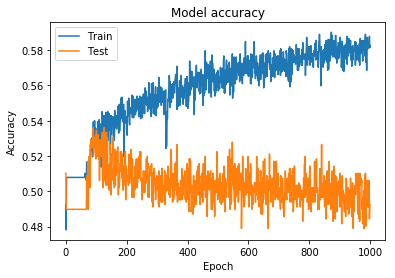

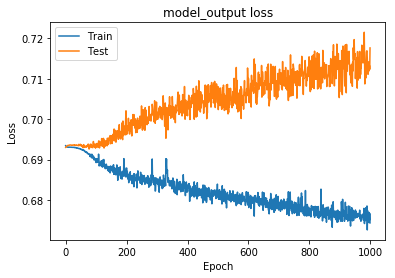

[[156 204]
 [169 206]]
0.5024390243902439


In [20]:
print('Training Accuracy : ' , np.mean(model_output.history["acc"]))
print('Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))

plt.plot(model_output.history['acc'])
plt.plot(model_output.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_output.history['loss'])
plt.plot(model_output.history['val_loss'])
plt.title('model_output loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

y_pred = model.predict(x_test)
rounded = [round(x[0]) for x in y_pred]
y_pred1 = np.array(rounded,dtype='int64')

print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))


# loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))


# print('Training Accuracy : ' , np.mean(model_output.history["acc"]))
# print('Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))



# # Plot training & validation accuracy values
# plt.plot(model_output.history['acc'])
# plt.plot(model_output.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(model_output.history['loss'])
# plt.plot(model_output.history['val_loss'])
# plt.title('model_output loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()